In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
device = "cuda"

### **STEP 1: Create Dataset and DataLoader**

In [2]:
# Transform
transform = transforms.Compose([
    transforms.Resize([28, 28]),  # [Height, Width]
    transforms.ToTensor()  # PIL image to torch.tensor
])

# Dataset
training_data = MNIST(root="data", train=True, transform=transform, target_transform=None, download=False)
test_data = MNIST(root="data", train=False, transform=transform, target_transform=None, download=False)

print(f"The MNIST dataset has {len(training_data)} training examples and {len(test_data)} test examples.\n")
print(f"Training set has the following attributes:\n- features shape: {training_data.data.shape}\n- targets shape: {training_data.targets.shape}\n")
print(f"Test set has the following attributes:\n- features shape: {test_data.data.shape}\n- targets shape: {test_data.targets.shape}")

The MNIST dataset has 60000 training examples and 10000 test examples.

Training set has the following attributes:
- features shape: torch.Size([60000, 28, 28])
- targets shape: torch.Size([60000])

Test set has the following attributes:
- features shape: torch.Size([10000, 28, 28])
- targets shape: torch.Size([10000])


In [3]:
# Extracted dataset of 0 and 1 digits
train_filter = (training_data.targets == 0) | (training_data.targets == 1)
test_filter = (test_data.targets == 0) | (test_data.targets == 1)

training_data.data = training_data.data[train_filter]
training_data.targets = training_data.targets[train_filter]

test_data.data = test_data.data[test_filter]
test_data.targets = test_data.targets[test_filter]

In [4]:
# __len__ method in any Dataset class allows the use of len().
print(f"The MNIST dataset has {len(training_data)} training examples and {len(test_data)} test examples of 0 and 1 digits.\n")
print(f"Training set has the following attributes:\n- features shape: {training_data.data.shape}\n- targets shape: {training_data.targets.shape}\n")
print(f"Test set has the following attributes:\n- features shape: {test_data.data.shape}\n- targets shape: {test_data.targets.shape}\n")

# __getitem__ in any Dataset class allows indexing with [].
image, label = training_data[0]
print(f"First training example's shape -> {image.shape} as (Channel, Height, Width) and the label of {label}.")

The MNIST dataset has 12665 training examples and 2115 test examples of 0 and 1 digits.

Training set has the following attributes:
- features shape: torch.Size([12665, 28, 28])
- targets shape: torch.Size([12665])

Test set has the following attributes:
- features shape: torch.Size([2115, 28, 28])
- targets shape: torch.Size([2115])

First training example's shape -> torch.Size([1, 28, 28]) as (Channel, Height, Width) and the label of 0.


In [5]:
# Create dataloader to batch the dataset
batch_size = 32
dataloader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
print(f"dataloader has generated {len(dataloader)} batches, with {len(training_data) // batch_size} complete batches and the last batch contains {len(training_data) % batch_size} examples.")

dataloader has generated 396 batches, with 395 complete batches and the last batch contains 25 examples.


In [6]:
images, labels = next(iter(dataloader))
print(f"Each images batch -> {images.shape}, {images.dtype}")
print(f"Each labels batch -> {labels.shape}, {labels.dtype}")

Each images batch -> torch.Size([32, 1, 28, 28]), torch.float32
Each labels batch -> torch.Size([32]), torch.int64


### **STEP 2: Create the model**

In [7]:
class DigitsClassifier(nn.Module):
    def __init__(self):
        super(DigitsClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 25)
        self.fc2 = nn.Linear(25, 15)
        self.fc3 = nn.Linear(15, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x.squeeze(1)

In [8]:
model = DigitsClassifier().to(device)
print(model)

DigitsClassifier(
  (fc1): Linear(in_features=784, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [9]:
# Test if the model is working okay regardless of the result
pred = model(torch.rand((batch_size, 1, 28, 28)).to(device))

print(f"Prediction's shape: {pred.shape}")
print(f"Prediction: {pred}")

Prediction's shape: torch.Size([32])
Prediction: tensor([0.5138, 0.5145, 0.5149, 0.5129, 0.5150, 0.5136, 0.5144, 0.5118, 0.5152,
        0.5150, 0.5139, 0.5166, 0.5151, 0.5156, 0.5142, 0.5164, 0.5148, 0.5135,
        0.5142, 0.5132, 0.5152, 0.5129, 0.5154, 0.5143, 0.5145, 0.5143, 0.5141,
        0.5132, 0.5155, 0.5145, 0.5152, 0.5149], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


### **STEP 3: The training loop**

In [10]:
# Create loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [11]:
# Test the loss function
gt = torch.rand(batch_size).to(device)
gt = (gt >= 0.5).float()
criterion(pred, gt)

tensor(0.6949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [12]:
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
# Training loop
num_epochs = 20
train_loss = []
validation_loss = []

for epoch in range(num_epochs):
    # Set to training mode
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Making inference
        outputs = model(inputs)
        
        # Compute the loss and its gradients (backprop)
        loss = criterion(outputs, targets.float())
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        
    train_loss.append(running_loss)
    
    # Set the model to evaluation mode
    model.eval()
    running_vloss = 0.0
    
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            vloss = criterion(outputs, targets.float())
            running_vloss += vloss.item()
    
    validation_loss.append(running_vloss)

    print(f"Epoch {epoch + 1} | train loss: {running_loss} | validation loss: {running_vloss}.")

print("FINISHED TRAINING!")

Epoch 1 | train loss: 98.31420223042369 | validation loss: 4.199846372008324.
Epoch 2 | train loss: 15.42141024582088 | validation loss: 1.4796390607953072.
Epoch 3 | train loss: 7.062669164501131 | validation loss: 0.8083544783294201.
Epoch 4 | train loss: 4.2912201238796115 | validation loss: 0.557508921250701.
Epoch 5 | train loss: 2.974753551185131 | validation loss: 0.4292644392699003.
Epoch 6 | train loss: 2.2749323958996683 | validation loss: 0.3899772521108389.
Epoch 7 | train loss: 1.7182468597311527 | validation loss: 0.3554476094432175.
Epoch 8 | train loss: 1.3414809063542634 | validation loss: 0.23488129570614547.
Epoch 9 | train loss: 1.0277296488638967 | validation loss: 0.23885125783272088.
Epoch 10 | train loss: 0.7227326508145779 | validation loss: 0.19939694163622335.
Epoch 11 | train loss: 0.6127875799429603 | validation loss: 0.16993087209993973.
Epoch 12 | train loss: 0.5356132062152028 | validation loss: 0.17628367530414835.
Epoch 13 | train loss: 0.4768848760286

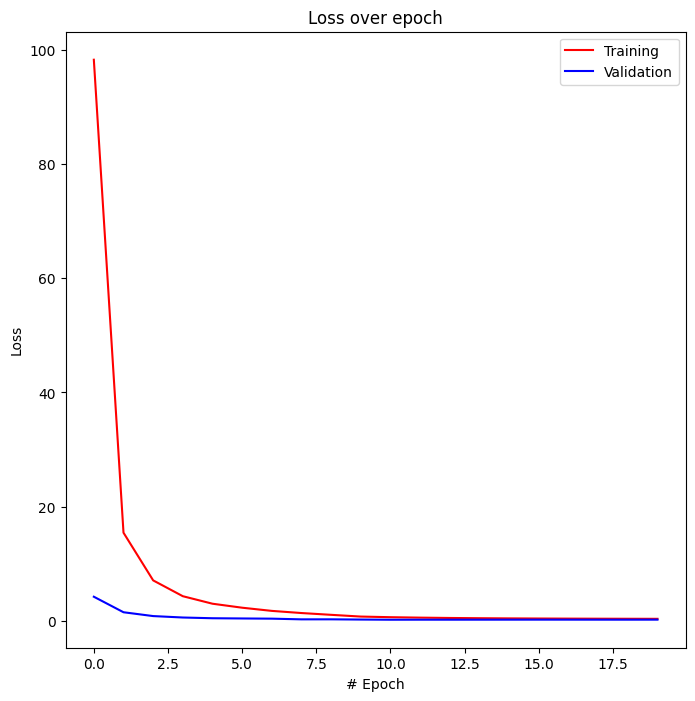

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(train_loss, label="Training", c='r')
plt.plot(validation_loss, label="Validation", c='b')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over epoch")
plt.show()

### **STEP 4: Making inferences**

In [15]:
# Setting the model to evaluation mode freezes the parameters
model.eval()

# Create an empty list to store all predictions
all_predictions = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        
        # Making inference
        probabilities = model(inputs)
        
        # Applying threshold
        predictions = (probabilities >= 0.5).float()
        
        all_predictions.append(predictions)
                
# Concatenate predictions from all batches into a single tensor
all_predictions = torch.cat(all_predictions)
print(f"We have made {len(all_predictions)} inferences.")

We have made 2115 inferences.


In [16]:
# Performance on the test set
acc = accuracy_score(test_data.targets.cpu(), all_predictions.cpu())
print(f"Accuracy of model: {acc * 100:.4f} %")

Accuracy of model: 99.9527 %


In [17]:
# Viewing misclassified examples
misclassified_indices = (all_predictions.to(device) != test_data.targets.to(device)).nonzero()
print(f"We have misclassified {len(misclassified_indices)} example(s).")

We have misclassified 1 example(s).


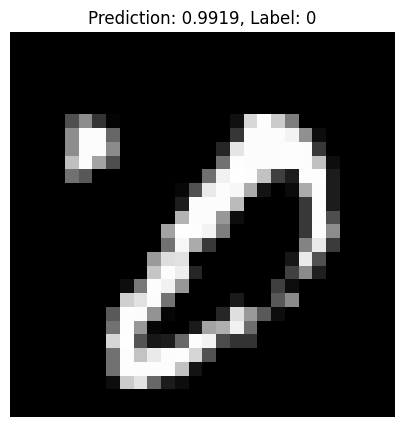

In [18]:
# Visualization
image, label = test_data[misclassified_indices[0].item()]
pred = model(image.to(device)).cpu()

plt.figure(figsize=(5, 5))
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"Prediction: {pred.item():.4f}, Label: {label}")
plt.show()